In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## Functions in Python

In [3]:
def simpleadd(a,b):
    return a+b

In [4]:
simpleadd(3,4)

7

In [5]:
def fibonacci(n):
    a, b = 0, 1
    for i in range(n):
        a, b = b, a + b
    return a

In [6]:
fibonacci(7)

13

In [7]:
for n in range(10):
    print(fibonacci(n))

0
1
1
2
3
5
8
13
21
34


## Laplace equation in 2D

The Laplace equation (used in heat transfer, potential flow...) in 2D coordinates is:

$$
\dfrac{\partial^2 p}{\partial x^2} + \dfrac{\partial^2 p}{\partial y^2} = 0
$$

This equation does not have time dependence (there is no $p^{n+1}$ term) - it will be solved until it reaches 'equilibrium'. Total equillibrium it is only reached at an $\infty$ number of equations, so it will be approximated when the change between iterations is very small. The equation can be discretized as:

$$
\dfrac{p_{i+1,j}^n-2p^n_{i,j}+p^n_{i-1,j}}{\Delta x^2} + \dfrac{p^n_{i,j+1}-2p^n_{i,j}+p^n_{i,j-1}}{\Delta y^2}=0
$$

Rearranging this equation and solving for $p^n_{i,j}$:

$$
p^n_{i,j}=\dfrac{\Delta y^2 \left( p^n_{i+1,j}+p^n_{i-1,j} \right) + \Delta x^2 \left( p^n_{i,j+1} +p^n_{i,j-1} \right)}{2(\Delta x^2 + \Delta y^2)}
$$

This interpolation is known as the **five-point difference operator**. The initial condition for the problem will be $p=0$ in the whole domain. The boundary conditions for the problem are:

$$
\begin{Bmatrix}
    p = 0 & \text{at} & x = 0 \\
    p = y & \text{at} & x = 2 \\
    \dfrac{\partial p}{\partial y} = 0 & \text{at} & y = 0, 1
\end{Bmatrix}
$$

Under the whole set of conditions said, there is one analytical solution for this Laplace's equations:

$$
p(x,y) = \dfrac{x}{4} - 4 \sum_{n=1,odd}^{\infty} \dfrac{1}{(n\pi)^2 \sinh(2n\pi)} \sinh (n\pi x) \cos (n\pi y)
$$

In [8]:
def plot2D(x, y, p):
    fig = plt.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(x,y)
    surf = ax.plot_surface(X, Y, p, rstride = 1, cstride = 1, cmap = cm.viridis, linewidth = 0, antialiased = False)
    ax.set_xlim(0,2)
    ax.set_ylim(0,1)
    ax.view_init(30,225)
    ax.set_xlabel('$x$')
    ax.set_xlabel('$y$')

In [41]:
def laplace2d(p, y, dx, dy, l1norm_target):
    l1norm = 1
    pn = np.empty_like(p)
    
    res = np.zeros(10000)
    
    i = 0
    res[i] = 1
    
    while l1norm > l1norm_target:
        i += 1
        
        pn = p.copy()
        p[1:-1, 1:-1] = ((dy**2 * (pn[1:-1, 2:] + pn[1:-1, 0:-2]) + dx**2 * (pn[2:, 1:-1] + pn[0:-2, 1:-1])) / (2 * (dx**2 + dy**2)))

        p[:, 0] = 0 
        p[:, -1] = y
        p[0,:] = p[1,:]
        p[-1,:] = p[-2,:]
                
        l1norm = (np.sum(np.abs(p[:])) - np.sum(np.abs(pn[:])))/(np.sum(np.abs(pn[:])))
        
        res[i] = l1norm
    
    resd = np.zeros(i)
    resd[:] = res[:i]
    
    return p, resd

In [42]:
nx = 31
ny = 31
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)

p = np.zeros((ny,nx))

x = np.linspace(0,2,nx)
y = np.linspace(0,1,ny)

p[:, 0] = 0 
p[:, -1] = y
p[0,:] = p[1,:]
p[-1,:] = p[-2,:]

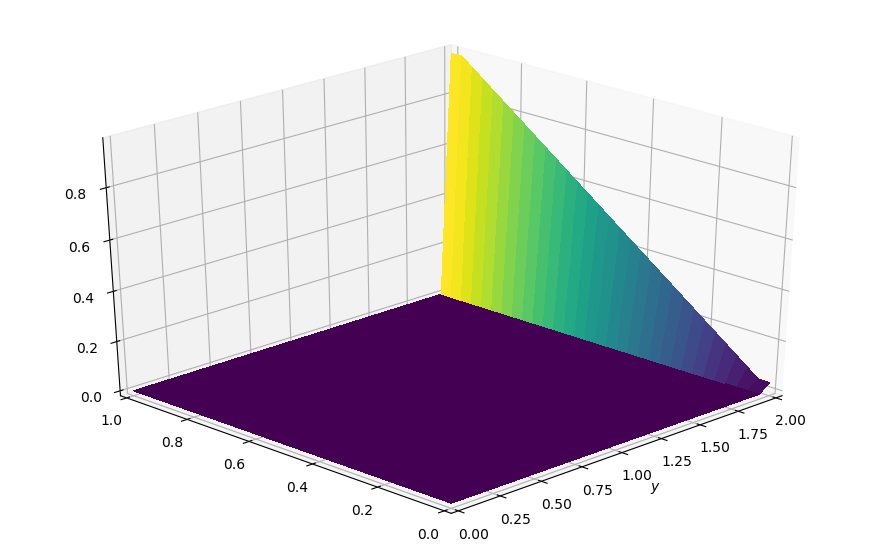

In [11]:
plot2D(x, y, p)

In [12]:
p, residuals = laplace2d(p, y, dx, dy, 1e-4)

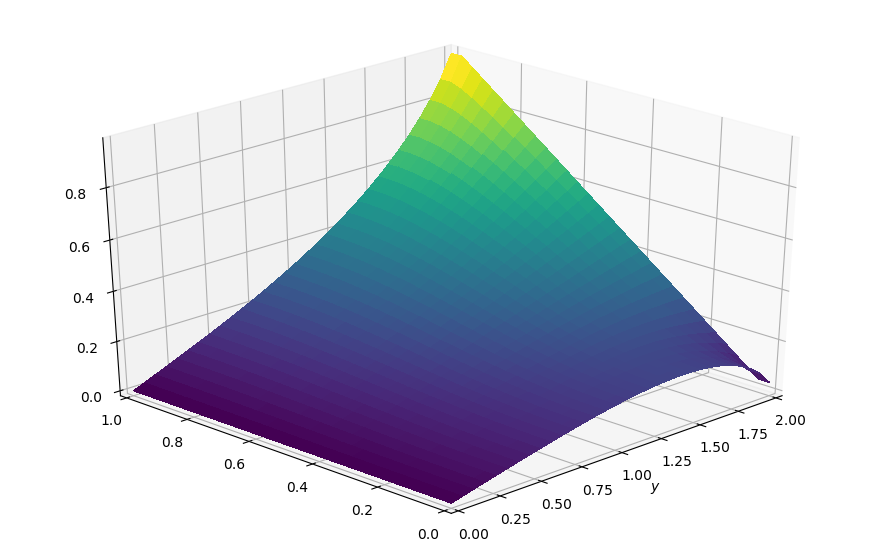

In [13]:
plot2D(x, y, p)

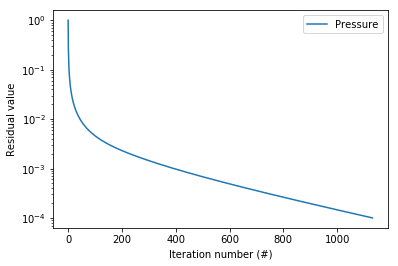

In [14]:
plt.semilogy(residuals, label='Pressure')
plt.xlabel('Iteration number (#)')
plt.ylabel('Residual value')
plt.legend()

## Loop optimization

In [43]:
p = np.zeros((ny,nx))

x = np.linspace(0,2,nx)
y = np.linspace(0,1,ny)

p[:, 0] = 0 
p[:, -1] = y
p[0,:] = p[1,:]
p[-1,:] = p[-2,:]

In [44]:
%%timeit
laplace2d(p, y, dx, dy, 1e-4)

51.2 µs ± 1.66 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Rewriting the Laplace 2D equation in the non-array operation form:

In [45]:
def laplace2d_vanilla(p, y, dx, dy, l1norm_target):
    l1norm = 1
    pn = np.empty_like(p)
    
    res = np.zeros(10000)
    
    i = 0
    res[i] = 1
    
    nx, ny = len(y), len(y)
    
    while l1norm < l1norm_target:
        i += 1
        pn = p.copy()
        
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                p[i, j] = ((dy**2 * (pn[i+1, j] + pn[i-1, j]) + dx**2 * (pn[i, j+1] + pn[i, j-1])) / (2 * (dx**2 + dy**2)))

        p[0, 0] = ((dy**2 * (pn[1, 0] + pn[-1, 0]) + dx**2 * (pn[0, 1] + pn[0, -1])) / (2 * (dx**2 + dy**2)))
        p[-1, -1] = ((dy**2 * (pn[0, -1] + pn[-2, -1]) + dx**2 * (pn[-1, 0] + pn[-1, -2])) / (2 * (dx**2 + dy**2)))
        
        p[:, 0] = 0 
        p[:, -1] = y
        p[0,:] = p[1,:]
        p[-1,:] = p[-2,:]
                
        l1norm = (np.sum(np.abs(p[:])) - np.sum(np.abs(pn[:])))/(np.sum(np.abs(pn[:])))
        
        res[i] = l1norm
    
    resd = np.zeros(i)
    resd[:] = res[:i]
    
    return p, resd

In [46]:
p = np.zeros((ny,nx))

x = np.linspace(0,2,nx)
y = np.linspace(0,1,ny)

p[:, 0] = 0 
p[:, -1] = y
p[0,:] = p[1,:]
p[-1,:] = p[-2,:]

In [47]:
%%timeit
laplace2d_vanilla(p, y, dx, dy, 1e-4)

7.9 µs ± 27.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [48]:
from numba import autojit

In [49]:
@autojit
def laplace2d_numba(p, y, dx, dy, l1norm_target):
    l1norm = 1
    pn = np.empty_like(p)
    
    res = np.zeros(10000)
    
    i = 0
    res[i] = 1
    
    while l1norm > l1norm_target:
        i += 1
        
        pn = p.copy()
        p[1:-1, 1:-1] = ((dy**2 * (pn[1:-1, 2:] + pn[1:-1, 0:-2]) + dx**2 * (pn[2:, 1:-1] + pn[0:-2, 1:-1])) / (2 * (dx**2 + dy**2)))

        p[:, 0] = 0 
        p[:, -1] = y
        p[0,:] = p[1,:]
        p[-1,:] = p[-2,:]
                
        l1norm = (np.sum(np.abs(p[:])) - np.sum(np.abs(pn[:])))/(np.sum(np.abs(pn[:])))
        
        res[i] = l1norm
    
    resd = np.zeros(i)
    resd[:] = res[:i]
    
    return p, resd

In [51]:
p = np.zeros((ny,nx))

x = np.linspace(0,2,nx)
y = np.linspace(0,1,ny)

p[:, 0] = 0 
p[:, -1] = y
p[0,:] = p[1,:]
p[-1,:] = p[-2,:]

In [52]:
%%timeit
laplace2d_numba(p, y, dx, dy, 1e-4)

16.4 µs ± 246 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [53]:
@autojit
def laplace2d_vanilla_numba(p, y, dx, dy, l1norm_target):
    l1norm = 1
    pn = np.empty_like(p)
    
    res = np.zeros(10000)
    
    i = 0
    res[i] = 1
    
    nx, ny = len(y), len(y)
    
    while l1norm < l1norm_target:
        i += 1
        pn = p.copy()
        
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                p[i, j] = ((dy**2 * (pn[i+1, j] + pn[i-1, j]) + dx**2 * (pn[i, j+1] + pn[i, j-1])) / (2 * (dx**2 + dy**2)))

        p[0, 0] = ((dy**2 * (pn[1, 0] + pn[-1, 0]) + dx**2 * (pn[0, 1] + pn[0, -1])) / (2 * (dx**2 + dy**2)))
        p[-1, -1] = ((dy**2 * (pn[0, -1] + pn[-2, -1]) + dx**2 * (pn[-1, 0] + pn[-1, -2])) / (2 * (dx**2 + dy**2)))
        
        p[:, 0] = 0 
        p[:, -1] = y
        p[0,:] = p[1,:]
        p[-1,:] = p[-2,:]
                
        l1norm = (np.sum(np.abs(p[:])) - np.sum(np.abs(pn[:])))/(np.sum(np.abs(pn[:])))
        
        res[i] = l1norm
    
    resd = np.zeros(i)
    resd[:] = res[:i]
    
    return p, resd

In [56]:
p = np.zeros((ny,nx))

x = np.linspace(0,2,nx)
y = np.linspace(0,1,ny)

p[:, 0] = 0 
p[:, -1] = y
p[0,:] = p[1,:]
p[-1,:] = p[-2,:]

In [57]:
%%timeit
laplace2d_vanilla_numba(p, y, dx, dy, 1e-4)

5.48 µs ± 28.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
